In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Attention,Concatenate,Dropout,Conv1D, MaxPool1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import numpy as np

# 文本预处理

In [20]:
import jieba
import os
import re

In [21]:
#导入停用词
stop_words = open('NLPIR_stopwords.txt','r',encoding='utf-8').read().split('\n')

# 为语料做分词处理
def word_segment():
    # 打开语料文本
    inputFile_NoSegment = open(os.getcwd() + '/对话内容/chatterbot.tsv', 'r', encoding='utf-8')#文本格式读取
    # 处理过的文本存档
    outputFile_Segment = open(os.getcwd() + '/对话内容/chatterbot.txt','w', encoding='utf-8')
    # 列表读取语料文本中的每一行文字 
    lines = inputFile_NoSegment.readlines()
    
    # 为每一行文字分词
    for i in range(len(lines)):
        line = lines[i]
        if line:
            line = line.strip()
            
            line=re.sub('[\\\'!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘\\\'！[\\]^_`{|}~]+','',line)#正则去除特殊字符
            line=re.sub('\t|\n|\s|\r',' ',line)#正则清洗多余换行空格
            line=re.sub('\s+',' ',line)
            
            seg_list = jieba.cut(line)#分词

            segments = ''
            for word in seg_list:
                #if word not in stop_words:#去停用词
                segments = segments + ' ' + word
            segments += '\n'
            segments = segments.lstrip()

            # 将分词后的语句，写进文件中
            outputFile_Segment.write(segments)

    inputFile_NoSegment.close()
    outputFile_Segment.close()

word_segment()

FileNotFoundError: [Errno 2] No such file or directory: 'NLPIR_stopwords.txt'

In [22]:
# 处理过的文本存档
outputFile_Segment = open(os.getcwd() + '/对话内容/clean_conversation_2.txt','w', encoding='utf-8')
with open(os.getcwd() + '/对话内容/clean_conversation.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(600, len(lines) - 1)]:
    input_t = line.split('\t')[0]
    target_t = line.split('\t')[1]
    input_t=re.sub('[\\\'!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘\\\'！[\\]^_`{|}~]+','',input_t)#正则去除特殊字符
    input_t=re.sub('\t|\n|\s|\r',' ',input_t)#正则清洗多余换行空格
    input_t=re.sub('\s+',' ',input_t)
    target_t=re.sub('[\\\'!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘\\\'！[\\]^_`{|}~]+','',target_t)#正则去除特殊字符
    target_t=re.sub('\t|\n|\s|\r',' ',target_t)#正则清洗多余换行空格
    target_t=re.sub('\s+',' ',target_t)
    outputFile_Segment.write((input_t + '\n').lstrip())
    outputFile_Segment.write((target_t+ '\n').lstrip())

# 文本导入

In [24]:
import os

# 读取处理过的文本
text_Segment = open(os.getcwd() + '/对话内容/Source_segment.txt','r', encoding='utf-8')
text_Segment_list = text_Segment.readlines()
text_Segment.close()
# 移除换行
text_Segment_list = [n.rstrip() for n in text_Segment_list]
if len(text_Segment_list)%2!=0:
    print("文本库数据有误 对话不对称 请检查！")
else:
    print('对话内容总数：', len(text_Segment_list))

对话内容总数： 3654


In [25]:
from collections import Counter

#<PAD>填充句子
#<UNK>替换词汇表里不存在的字符
#<GO>句子输入的开始, 即第一个时间步长的输入
#<EOS>句子输入的结束.

def fit_text(X, Y, input_seq_max_length=None, target_seq_max_length=None):
    if input_seq_max_length is None:
        input_seq_max_length = MAX_INPUT_SEQ_LENGTH
    if target_seq_max_length is None:
        target_seq_max_length = MAX_TARGET_SEQ_LENGTH
    input_counter = Counter()
    target_counter = Counter()
    max_input_seq_length = 0
    max_target_seq_length = 0

    for line in X:
        text = [word.lower() for word in line.split(' ')]
        seq_length = len(text)
        if seq_length > input_seq_max_length:
            text = text[0:input_seq_max_length]
            seq_length = len(text)
        for word in text:
            input_counter[word] += 1
        max_input_seq_length = max(max_input_seq_length, seq_length)

    for line in Y:
        line2 = 'START ' + line.lower() + ' END'
        text = [word for word in line2.split(' ')]
        seq_length = len(text)
        if seq_length > target_seq_max_length:
            text = text[0:target_seq_max_length]
            seq_length = len(text)
        for word in text:
            target_counter[word] += 1
            max_target_seq_length = max(max_target_seq_length, seq_length)

    input_word2idx = dict()
    for idx, word in enumerate(input_counter.most_common(MAX_INPUT_VOCAB_SIZE)):
        input_word2idx[word[0]] = idx + 2
    input_word2idx['PAD'] = 0
    input_word2idx['UNK'] = 1
    input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])

    target_word2idx = dict()
    for idx, word in enumerate(target_counter.most_common(MAX_TARGET_VOCAB_SIZE)):
        target_word2idx[word[0]] = idx + 1
    target_word2idx['UNK'] = 0

    target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])
    
    num_input_tokens = len(input_word2idx)
    num_target_tokens = len(target_word2idx)
    #词向量
    config = dict()
    config['input_word2idx'] = input_word2idx
    config['input_idx2word'] = input_idx2word
    config['target_word2idx'] = target_word2idx
    config['target_idx2word'] = target_idx2word
    config['num_input_tokens'] = num_input_tokens
    config['num_target_tokens'] = num_target_tokens
    config['max_input_seq_length'] = max_input_seq_length
    config['max_target_seq_length'] = max_target_seq_length

    return config

* ### Seq2Seq模型框架  
![model](./reports/model.png)
    
    
* ### encoder端  
![encoder](./reports/self.encoder_model.png)
    
    
* ### decoder端 
![decoder](./reports/self.decoder_model.png)

# Seq2Seq模型（生成器）

## 模型配置

In [26]:
MAX_INPUT_SEQ_LENGTH = 14 # 编码器输入长度
MAX_TARGET_SEQ_LENGTH = 20 # 解码器输出长度
MAX_INPUT_VOCAB_SIZE = 5000# 编码器词向量大小
MAX_TARGET_VOCAB_SIZE = 5000 # 解码器词向量大小
HIDDEN_UNITS = 188 #隐藏层s
DEFAULT_BATCH_SIZE = 64 #批次（若文本量较小 需要降低）
VERBOSE = 1 #日志
USER_EPOCHS = 400 #自定义轮数
DEFAULT_EPOCHS = 10 #默认轮数
LEARNING_RATE = 0.001 #学习率

In [27]:
X = text_Segment_list[0:][::2] # 输入问句
Y = text_Segment_list[1:][::2] # 输出答句
config = fit_text(X, Y)

print('num_input_tokens: ', config['num_input_tokens'])
print('num_target_tokens: ', config['num_target_tokens'])
print('max_input_seq_length: ', config['max_input_seq_length'])
print('max_target_seq_length: ', config['max_target_seq_length'])

num_input_tokens:  1379
num_target_tokens:  2485
max_input_seq_length:  14
max_target_seq_length:  20


In [21]:
from __future__ import print_function
import os

class Seq2SeqSummarizer(object):

    model_name = 'seq2seq'

    def __init__(self, config):
        #Seq2Seq模型定义
        self.num_input_tokens = config['num_input_tokens']
        self.max_input_seq_length = config['max_input_seq_length']
        self.num_target_tokens = config['num_target_tokens']
        self.max_target_seq_length = config['max_target_seq_length']
        self.input_word2idx = config['input_word2idx']
        self.input_idx2word = config['input_idx2word']
        self.target_word2idx = config['target_word2idx']
        self.target_idx2word = config['target_idx2word']
        self.config = config

        self.version = 0
        if 'version' in config:
            self.version = config['version']
        #编码器
        encoder_inputs = Input(shape=(None,), name='encoder_inputs')
        encoder_embedding = Embedding(input_dim=self.num_input_tokens, # 词汇表大小
                                      output_dim=HIDDEN_UNITS, # 词向量维度
                                      input_length=self.max_input_seq_length, # 输入序列的长度
                                      name='encoder_embedding')
        encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
        
        encoder_states = [encoder_state_h, encoder_state_c]
        #解码器
        decoder_inputs = Input(shape=(None, self.num_target_tokens), name='decoder_inputs')
        decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
        decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                         initial_state=encoder_states)
        
        #注意力层
        attention = Attention(name='attention_layer')
        attention_output = attention([decoder_outputs,encoder_outputs])
        
        decoder_concat = Concatenate(axis=-1, name='concat_layer')
        decoder_concat_input = decoder_concat([decoder_outputs, attention_output])
        #随机失活
        #decoder_dropout = Dropout(0.2)
        #decoder_concat_input = decoder_dropout(decoder_concat_input)
        decoder_dense = Dense(units=self.num_target_tokens, activation='softmax', name='decoder_dense')
        
        decoder_outputs = decoder_dense(decoder_concat_input)

        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        plot_model(model, to_file='./reports/model.png',show_shapes=True)
        
        #模型训练
        #model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=LEARNING_RATE), metrics=['accuracy'])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        #单独定义编码器解码器 便于预测时使用
        self.model = model
        #编码器模型输出和隐藏层码
        self.encoder_model = Model(encoder_inputs,[encoder_outputs,encoder_states])
        #self.encoder_model = Model(encoder_inputs,encoder_states)
        plot_model(self.encoder_model, to_file='./reports/self.encoder_model.png',show_shapes=True)

        decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        #注意力层
        attention_output  = attention([decoder_outputs,encoder_outputs])
        decoder_concat_input = decoder_concat([decoder_outputs, attention_output])
        #decoder_concat_input = decoder_dropout(decoder_concat_input)
        decoder_outputs = decoder_dense(decoder_concat_input)
        #解码器输出预测
        self.decoder_model = Model([decoder_inputs,encoder_outputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)
        self.decoder_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        plot_model(self.decoder_model, to_file='./reports/self.decoder_model.png',show_shapes=True)

        #加载权重
    def load_weights(self, weight_file_path,decoder_weight_file_path):
        if os.path.exists(weight_file_path):
            self.model.load_weights(weight_file_path)
            self.decoder_model.load_weights(decoder_weight_file_path)
    
    #将输入的文本转换为词向量
    def transform_input_text(self, texts):
        temp = []
        for line in texts:
            x = []
            for word in line.lower().split(' '):
                wid = 1
                if word in self.input_word2idx:
                    wid = self.input_word2idx[word]
                x.append(wid)
                if len(x) >= self.max_input_seq_length:
                    break
            temp.append(x)
        temp = pad_sequences(temp, maxlen=self.max_input_seq_length)

        print(temp.shape)
        return temp
    
    #辨别器数据向量化
    def tokenize(self, texts):
        temp = []
        for line in texts:
            x = []
            for word in line.lower().split(' '):
                wid = 1
                if word in self.input_word2idx:
                    wid = self.input_word2idx[word]
                x.append(wid)
                if len(x) >= self.max_target_seq_length:
                    break
            temp.append(x)
        temp = pad_sequences(temp, maxlen=self.max_target_seq_length)

        print(temp.shape)
        return temp
    
    #增加开始结束标签
    def transform_target_encoding(self, texts):
        temp = []
        for line in texts:
            x = []
            line2 = 'START ' + line.lower() + ' END'
            for word in line2.split(' '):
                if len(x) >= self.max_target_seq_length:
                    x[self.max_target_seq_length-1] = 'END'
                    break
                x.append(word)
            temp.append(x)

        temp = np.array(temp)
        print(temp.shape)
        return temp

    #批次训练
    def generate_batch(self, x_samples, y_samples, batch_size):
        num_batches = len(x_samples) // batch_size
        while True:
            for batchIdx in range(0, num_batches):
                start = batchIdx * batch_size
                end = (batchIdx + 1) * batch_size
                encoder_input_data_batch = pad_sequences(x_samples[start:end], self.max_input_seq_length)
                decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
                decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
                for lineIdx, target_words in enumerate(y_samples[start:end]):
                    for idx, w in enumerate(target_words):
                        w2idx = 0  # default [UNK]
                        if w in self.target_word2idx:
                            w2idx = self.target_word2idx[w]
                        if w2idx != 0:
                            decoder_input_data_batch[lineIdx, idx, w2idx] = 1
                            if idx > 0:
                                decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
                yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch
    def generate_batch2(x_samples, y_samples, batch_size = 64,num_batches=1):
        self = summarizer
        start = 0
        end = batch_size
        encoder_input_data_batch = pad_sequences(x_samples[start:end], summarizer.max_input_seq_length)
        decoder_target_data_batch = np.zeros(shape=(batch_size, summarizer.max_target_seq_length, summarizer.num_target_tokens))
        decoder_input_data_batch = np.zeros(shape=(batch_size, summarizer.max_target_seq_length, summarizer.num_target_tokens))
        for lineIdx, target_words in enumerate(y_samples[start:end]):
            for idx, w in enumerate(target_words):
                w2idx = 0  # default [UNK]
                if w in self.target_word2idx:
                    w2idx = self.target_word2idx[w]
                if w2idx != 0:
                    decoder_input_data_batch[lineIdx, idx, w2idx] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
        return [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch
    @staticmethod
    def get_weight_file_path(model_dir_path):#权重
        return model_dir_path + '/' + Seq2SeqSummarizer.model_name + '-weights.h5'
    @staticmethod
    def get_decoder_weight_file_path(model_dir_path):#权重
        return model_dir_path + '/' + 'decoder-weights.h5'
    @staticmethod
    def get_config_file_path(model_dir_path):#配置
        return model_dir_path + '/' + Seq2SeqSummarizer.model_name + '-config.npy'

    @staticmethod
    def get_architecture_file_path(model_dir_path):#结构
        return model_dir_path + '/' + Seq2SeqSummarizer.model_name + '-architecture.json'

    #预测
    def fit(self, Xtrain, Ytrain, Xtest, Ytest, epochs=None, batch_size=None, model_dir_path=None):
        if epochs is None:
            epochs = DEFAULT_EPOCHS
        if model_dir_path is None:
            model_dir_path = './models'
        if batch_size is None:
            batch_size = DEFAULT_BATCH_SIZE

        self.version += 1
        self.config['version'] = self.version
        #读取网络配置
        config_file_path = Seq2SeqSummarizer.get_config_file_path(model_dir_path)
        weight_file_path = Seq2SeqSummarizer.get_weight_file_path(model_dir_path)
        decoder_weight_file_path = Seq2SeqSummarizer.get_decoder_weight_file_path(model_dir_path)
        checkpoint = ModelCheckpoint(weight_file_path)
        np.save(config_file_path, self.config)
        architecture_file_path = Seq2SeqSummarizer.get_architecture_file_path(model_dir_path)
        open(architecture_file_path, 'w').write(self.model.to_json())

        Ytrain = self.transform_target_encoding(Ytrain)
        Ytest = self.transform_target_encoding(Ytest)

        Xtrain = self.transform_input_text(Xtrain)
        Xtest = self.transform_input_text(Xtest)

        train_gen = self.generate_batch(Xtrain, Ytrain, batch_size)
        test_gen = self.generate_batch(Xtest, Ytest, batch_size)

        train_num_batches = len(Xtrain) // batch_size
        test_num_batches = len(Xtest) // batch_size

        history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                           epochs=epochs,
                                           verbose=VERBOSE, validation_data=test_gen, validation_steps=test_num_batches,
                                           callbacks=[checkpoint])
        self.model.save_weights(weight_file_path)#保存模型权重
        self.decoder_model.save_weights(decoder_weight_file_path)#保存模型权重
        return history
    
    def summarize(self, input_text):
        input_seq = []
        input_wids = []
        for word in input_text.lower().split(' '):
            idx = 1  # default [UNK]
            if word in self.input_word2idx:
                idx = self.input_word2idx[word]
            input_wids.append(idx)
        input_seq.append(input_wids)
        input_seq = pad_sequences(input_seq, self.max_input_seq_length)
        encoder_outputs,states_value = self.encoder_model.predict(input_seq)
        #states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_target_tokens))
        target_seq[0, 0, self.target_word2idx['START']] = 1
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            #print (target_seq.shape)
            #print (np.array(states_value).shape)
            output_tokens, h, c = self.decoder_model.predict([target_seq,encoder_outputs] + states_value)
            #print (np.array(output_tokens).shape)
            #print (np.array(h).shape)
            #print (np.array(c).shape)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'START' and sample_word != 'END':
                target_text += ' ' + sample_word

            if sample_word == 'END' or target_text_len >= self.max_target_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, self.num_target_tokens))
            target_seq[0, 0, sample_token_idx] = 1

            states_value = [h, c]
        return target_text.strip()

## 训练过程

In [7]:
from matplotlib import pyplot as plt
%notebook inline

def create_history_plot(history, model_name, metrics=None):
    plt.title('Accuracy and Loss (' + model_name + ')')
    if metrics is None:
        metrics = {'acc', 'loss'}
    if 'acc' in metrics:
        plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
    if 'loss' in metrics:
        plt.plot(history.history['loss'], color='r', label='Train Loss')
        plt.plot(history.history['val_loss'], color='m', label='Validation Loss')
    plt.legend(loc='best')

    plt.tight_layout()


def plot_history(history, model_name):
    create_history_plot(history, model_name)
    plt.show()


def plot_and_save_history(history, model_name, file_path, metrics=None):
    if metrics is None:
        metrics = {'acc', 'loss'}
    create_history_plot(history, model_name, metrics)
    plt.savefig(file_path)


training size:  1644
testing size:  183
start fitting ...
(1644,)
(183,)
(1644, 14)
(183, 14)
Epoch 1/400


C:\Users\taki\AppData\Local\Temp/ipykernel_7864/2783105689.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(temp)
C:\Users\taki\AppData\Local\Temp/ipykernel_7864/2783105689.py:210: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,


25/25 [==============================] - 6s 76ms/step - loss: 3.0216 - accuracy: 0.0477 - val_loss: 2.6236 - val_accuracy: 0.0590
Epoch 2/400
25/25 [==============================] - 1s 40ms/step - loss: 2.6604 - accuracy: 0.0562 - val_loss: 2.6455 - val_accuracy: 0.0582
Epoch 3/400
25/25 [==============================] - 1s 40ms/step - loss: 2.6469 - accuracy: 0.0559 - val_loss: 2.6260 - val_accuracy: 0.0574
Epoch 4/400
25/25 [==============================] - 1s 41ms/step - loss: 2.6325 - accuracy: 0.0563 - val_loss: 2.6184 - val_accuracy: 0.0574
Epoch 5/400
25/25 [==============================] - 1s 41ms/step - loss: 2.6204 - accuracy: 0.0564 - val_loss: 2.6177 - val_accuracy: 0.0574
Epoch 6/400
25/25 [==============================] - 1s 40ms/step - loss: 2.6128 - accuracy: 0.0571 - val_loss: 2.6171 - val_accuracy: 0.0574
Epoch 7/400
25/25 [==============================] - 1s 44ms/step - loss: 2.6072 - accuracy: 0.0581 - val_loss: 2.6166 - val_accuracy: 0.0594
Epoch 8/400
25/25 

25/25 [==============================] - 1s 51ms/step - loss: 1.8817 - accuracy: 0.1567 - val_loss: 2.3323 - val_accuracy: 0.1262
Epoch 116/400
25/25 [==============================] - 1s 47ms/step - loss: 1.8723 - accuracy: 0.1583 - val_loss: 2.3482 - val_accuracy: 0.1234
Epoch 117/400
25/25 [==============================] - 1s 45ms/step - loss: 1.8604 - accuracy: 0.1602 - val_loss: 2.3510 - val_accuracy: 0.1223
Epoch 118/400
25/25 [==============================] - 1s 52ms/step - loss: 1.8498 - accuracy: 0.1622 - val_loss: 2.3458 - val_accuracy: 0.1246
Epoch 119/400
25/25 [==============================] - 1s 49ms/step - loss: 1.8403 - accuracy: 0.1635 - val_loss: 2.3370 - val_accuracy: 0.1246
Epoch 120/400
25/25 [==============================] - 1s 52ms/step - loss: 1.8315 - accuracy: 0.1649 - val_loss: 2.3330 - val_accuracy: 0.1270
Epoch 121/400
25/25 [==============================] - 1s 47ms/step - loss: 1.8244 - accuracy: 0.1662 - val_loss: 2.3271 - val_accuracy: 0.1289
Epoch 

Epoch 172/400
25/25 [==============================] - 1s 40ms/step - loss: 1.5300 - accuracy: 0.2081 - val_loss: 2.3230 - val_accuracy: 0.1465
Epoch 173/400
25/25 [==============================] - 1s 39ms/step - loss: 1.5543 - accuracy: 0.2031 - val_loss: 2.3071 - val_accuracy: 0.1453
Epoch 174/400
25/25 [==============================] - 1s 39ms/step - loss: 1.5377 - accuracy: 0.2055 - val_loss: 2.2796 - val_accuracy: 0.1437
Epoch 175/400
25/25 [==============================] - 1s 39ms/step - loss: 1.5269 - accuracy: 0.2071 - val_loss: 2.3156 - val_accuracy: 0.1504
Epoch 176/400
25/25 [==============================] - 1s 40ms/step - loss: 1.5116 - accuracy: 0.2099 - val_loss: 2.2928 - val_accuracy: 0.1484
Epoch 177/400
25/25 [==============================] - 1s 40ms/step - loss: 1.4965 - accuracy: 0.2139 - val_loss: 2.2817 - val_accuracy: 0.1512
Epoch 178/400
25/25 [==============================] - 1s 40ms/step - loss: 1.4905 - accuracy: 0.2142 - val_loss: 2.2994 - val_accuracy:

Epoch 229/400
25/25 [==============================] - 1s 39ms/step - loss: 1.3058 - accuracy: 0.2419 - val_loss: 2.5075 - val_accuracy: 0.1520
Epoch 230/400
25/25 [==============================] - 1s 39ms/step - loss: 1.3103 - accuracy: 0.2409 - val_loss: 2.4672 - val_accuracy: 0.1551
Epoch 231/400
25/25 [==============================] - 1s 39ms/step - loss: 1.3060 - accuracy: 0.2421 - val_loss: 2.3778 - val_accuracy: 0.1586
Epoch 232/400
25/25 [==============================] - 1s 39ms/step - loss: 1.2916 - accuracy: 0.2437 - val_loss: 2.3525 - val_accuracy: 0.1582
Epoch 233/400
25/25 [==============================] - 1s 43ms/step - loss: 1.2959 - accuracy: 0.2439 - val_loss: 2.3941 - val_accuracy: 0.1609
Epoch 234/400
25/25 [==============================] - 1s 40ms/step - loss: 1.2817 - accuracy: 0.2460 - val_loss: 2.4820 - val_accuracy: 0.1559
Epoch 235/400
25/25 [==============================] - 1s 39ms/step - loss: 1.2733 - accuracy: 0.2475 - val_loss: 2.4613 - val_accuracy:

Epoch 286/400
25/25 [==============================] - 1s 39ms/step - loss: 1.1073 - accuracy: 0.2738 - val_loss: 2.5391 - val_accuracy: 0.1625
Epoch 287/400
25/25 [==============================] - 1s 39ms/step - loss: 1.1037 - accuracy: 0.2746 - val_loss: 2.5152 - val_accuracy: 0.1617
Epoch 288/400
25/25 [==============================] - 1s 42ms/step - loss: 1.0993 - accuracy: 0.2746 - val_loss: 2.5095 - val_accuracy: 0.1633
Epoch 289/400
25/25 [==============================] - 1s 43ms/step - loss: 1.0988 - accuracy: 0.2752 - val_loss: 2.5204 - val_accuracy: 0.1645
Epoch 290/400
25/25 [==============================] - 1s 43ms/step - loss: 1.1005 - accuracy: 0.2742 - val_loss: 2.5523 - val_accuracy: 0.1641
Epoch 291/400
25/25 [==============================] - 1s 43ms/step - loss: 1.1016 - accuracy: 0.2742 - val_loss: 2.6074 - val_accuracy: 0.1602
Epoch 292/400
25/25 [==============================] - 1s 43ms/step - loss: 1.1041 - accuracy: 0.2729 - val_loss: 2.6355 - val_accuracy:

Epoch 343/400
25/25 [==============================] - 1s 40ms/step - loss: 1.0078 - accuracy: 0.2892 - val_loss: 2.6959 - val_accuracy: 0.1652
Epoch 344/400
25/25 [==============================] - 1s 40ms/step - loss: 1.0054 - accuracy: 0.2902 - val_loss: 2.6509 - val_accuracy: 0.1656
Epoch 345/400
25/25 [==============================] - 1s 41ms/step - loss: 1.0036 - accuracy: 0.2904 - val_loss: 2.6273 - val_accuracy: 0.1656
Epoch 346/400
25/25 [==============================] - 1s 40ms/step - loss: 1.0185 - accuracy: 0.2868 - val_loss: 2.6966 - val_accuracy: 0.1664
Epoch 347/400
25/25 [==============================] - 1s 39ms/step - loss: 1.0208 - accuracy: 0.2863 - val_loss: 2.6650 - val_accuracy: 0.1672
Epoch 348/400
25/25 [==============================] - 1s 40ms/step - loss: 1.0149 - accuracy: 0.2876 - val_loss: 2.6346 - val_accuracy: 0.1680
Epoch 349/400
25/25 [==============================] - 1s 48ms/step - loss: 1.0238 - accuracy: 0.2842 - val_loss: 2.7408 - val_accuracy:

Epoch 400/400
25/25 [==============================] - 1s 43ms/step - loss: 0.9381 - accuracy: 0.3006 - val_loss: 2.8126 - val_accuracy: 0.1711


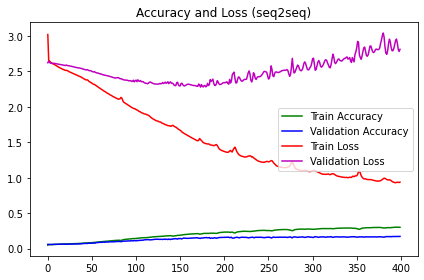

In [8]:
from sklearn.model_selection import train_test_split

report_dir_path = './reports'
model_dir_path = './models'

if not os.path.exists(report_dir_path):
    os.mkdir(report_dir_path)
    
if not os.path.exists(model_dir_path):
    os.mkdir(model_dir_path)

summarizer = Seq2SeqSummarizer(config)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=42)#分割数据集

print('training size: ', len(Xtrain))
print('testing size: ', len(Xtest))

print('start fitting ...')
history = summarizer.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=USER_EPOCHS)

#绘出训练过程
history_plot_file_path = report_dir_path + '/' + Seq2SeqSummarizer.model_name + '-history.png'
plot_and_save_history(history, summarizer.model_name, history_plot_file_path, metrics={'loss', 'acc'})

## 测试

 ### 加载模型

In [52]:
import numpy as np

model_dir_path = './models'
config = np.load(Seq2SeqSummarizer.get_config_file_path(model_dir_path=model_dir_path), allow_pickle=True).item()

summarizer = Seq2SeqSummarizer(config)
summarizer.load_weights(weight_file_path=Seq2SeqSummarizer.get_weight_file_path(model_dir_path=model_dir_path),
                       decoder_weight_file_path=Seq2SeqSummarizer.get_decoder_weight_file_path(model_dir_path=model_dir_path)
                       )

### 随机文本库预测

In [54]:
print('开始预测...')
for i in np.random.permutation(np.arange(len(X)))[0:10]:#随机在文本库中挑选语句
    x = X[i]
    actual_response = Y[i]
    response = summarizer.summarize(x)
    print('随机问题: ', x)
    print('机器人回复: ', response)
    print('文本库原回复: ', actual_response)
    print('='*100, '\n')

开始预测...
随机问题:  我 不想 去
机器人回复:  那 真是 太好了 内 一下 喔
文本库原回复:  为 什么 不想 去 呢

随机问题:  可是 我 没 有 伴
机器人回复:  可以 问问 看 朋友 或是 家人 的 意愿
文本库原回复:  可以 问问 看 朋友 或是 家人 的 意愿 呀

随机问题:  对 呀 感觉 很励 志
机器人回复:  那 就 忘记 路上 这份 喔
文本库原回复:  可以 和 大家 分享 这份 喜悦 唷

随机问题:  玩笑
机器人回复:  好 的 帮 你 关闭
文本库原回复:  你 什么 时候 过 马路 和 草莓 你 得到 了 什么

随机问题:  国庆节 连假 要 去 哪 玩
机器人回复:  可以 出去 家人 或 朋友 出去 买来 吃 或是 在家
文本库原回复:  可以 出去 旅游 或 跟 朋友 出去 聚餐 或是 在家 好好 休息 做些 休闲 娱乐

随机问题:  我 好 害怕
机器人回复:  好 的 好喝 音乐
文本库原回复:  你 看 起来 是 开心 的 是不是 因为 你 把 害怕 的 事藏 在 心里 了 呢

随机问题:  复杂 优于 晦涩
机器人回复:  你 似乎 很 熟悉
文本库原回复:  做 也许 好过 不 做

随机问题:  我 最近 都 有 做 瑜珈 唷
机器人回复:  那 真是 太好了
文本库原回复:  不错 唷 训练 身体 的 柔 软度

随机问题:  好热
机器人回复:  那要 多 穿衣服 喔 需要 帮 你 电暖炉 吗
文本库原回复:  要 帮 你 打开 电风扇 还是 冷气

随机问题:  我过 得 很 幸福
机器人回复:  可以 帮 你 的
文本库原回复:  为 什么 呢



### 单句预测

In [145]:
import jieba
#分词
def segment_one_sentence(sentence):
    sentence = sentence.strip()
    seg_list = jieba.cut(sentence)

    segments = ''
    for word in seg_list:
        segments = segments + ' ' + word
        
    return segments

In [99]:
#单句输入
input_X = '看看你'
input_X = segment_one_sentence(input_X)

print('你输入的内容:', input_X)
print('机器人的回复:', summarizer.summarize(input_X))

你输入的内容:  看看 你
机器人的回复: 是 啊 伤心 启示录 我


# CNN模型（判别器）

In [35]:
pretrained_discriminator_file = './models/discriminator.h5'
dis_filter_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
dis_num_filters = [100, 200, 200, 200, 200, 100, 100, 100, 100, 100, 160, 160]
num_batches = (len(X) // DEFAULT_BATCH_SIZE)

## 生成辨别器数据

In [36]:
def Predata():
    #存储方便调用
    #原始文本
    data = []
    for _ in range(num_batches):
        for i in np.random.permutation(np.arange(len(X)))[0:DEFAULT_BATCH_SIZE]:#随机在文本库中挑选语句
            actual_response = Y[i]
            response = summarizer.summarize(X[i])
            #附加
            data.append(actual_response)
            data.append(response)
    #返回序列化数据
    np.savetxt('./discridata/data.txt', summarizer.tokenize(data), delimiter=' ', fmt='%i')

Predata()


NameError: name 'summarizer' is not defined

## 读取辨别器数据

In [29]:
discridata = []
labels = []
with open(os.getcwd() + '/discridata/data.txt') as fin:
    for line in fin:
        line = line.strip().split()
        #将读取的数据转为int类型 否则无法送入模型
        parse_line = [int(x) for x in line]
        if len(parse_line) == 20:
            discridata.append(parse_line)
        #labels.append([1, 0])
    for i in range(int(len(discridata)/2)):
        labels.append([0, 1])
        labels.append([1, 0])

## 定义CNN模型

In [37]:
from __future__ import print_function

#Highway神经网络模型https://arxiv.org/pdf/1505.00387.pdf
class Highway(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super(Highway, self).__init__(**kwargs)

    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.dense_g = Dense(output_dim, activation="relu")
        self.dense_t = Dense(output_dim, activation="sigmoid")

    def call(self, input_tensor, training=False):
        g = self.dense_g(input_tensor, training=training)
        t = self.dense_t(input_tensor, training=training)
        o = t * g + (1. - t) * input_tensor
        return o


class Discriminator:
    #使用CNN作为分类
    def __init__(
            self, sequence_length, num_classes, vocab_size,
            embedding_size, filter_sizes, num_filters, dropout_keep_prob, l2_reg_lambda=0.0):
        self.sequence_length = sequence_length#序列长度
        self.num_classes = num_classes#分类
        self.vocab_size = vocab_size#词汇表大小
        self.embedding_size = embedding_size#嵌入层
        #模型输入
        layer_input = Input((sequence_length,), dtype=tf.int32)
        layer_emb = Embedding(vocab_size, embedding_size,
                              embeddings_initializer=tf.random_uniform_initializer(-1.0, 1.0))(layer_input)

        pooled_outputs = []
        for filter_size, num_filter in zip(filter_sizes, num_filters):#滤波器大小、数量
            x = Conv1D(num_filter, filter_size)(layer_emb)#卷积
            x = MaxPool1D(sequence_length - filter_size + 1)(x)#池化
            pooled_outputs.append(x)
        #合并输入
        x = Concatenate()(pooled_outputs)
        #打平
        x = Flatten()(x)
        x = Highway()(x)
        #随机失活
        x = Dropout(1.0 - dropout_keep_prob)(x)
        layer_output = Dense(num_classes,
                             kernel_regularizer=tf.keras.regularizers.l2(l2_reg_lambda),
                             bias_regularizer=tf.keras.regularizers.l2(l2_reg_lambda),
                             activation="softmax")(x)

        self.d_model = Model(layer_input, layer_output)
        plot_model(self.d_model, to_file='./reports/dis_model.png',show_shapes=True)
        d_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.d_model.compile(optimizer=d_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    def train(self, dataset, num_epochs, num_steps, **kwargs):
        return self.d_model.fit(dataset.repeat(num_epochs), verbose=1, epochs=num_epochs, steps_per_epoch=num_steps,
                                **kwargs)

    def save(self, filename):
        self.d_model.save_weights(filename, save_format="h5")

    def load(self, filename):
        self.d_model.load_weights(filename)

In [38]:
discriminator = Discriminator(sequence_length=MAX_TARGET_SEQ_LENGTH, num_classes=2, vocab_size=MAX_TARGET_VOCAB_SIZE,
                                  embedding_size=HIDDEN_UNITS,
                                  filter_sizes=dis_filter_sizes, num_filters=dis_num_filters,
                                  dropout_keep_prob=0.75,
                                  l2_reg_lambda=0.2)

## 训练

In [14]:
#初始化辨别器模型
discriminator = Discriminator(sequence_length=MAX_TARGET_SEQ_LENGTH, num_classes=2, vocab_size=MAX_TARGET_VOCAB_SIZE,
                                  embedding_size=HIDDEN_UNITS,
                                  filter_sizes=dis_filter_sizes, num_filters=dis_num_filters,
                                  dropout_keep_prob=0.75,
                                  l2_reg_lambda=0.2)

if not os.path.exists(pretrained_discriminator_file):
        print('开始预训练判别器')
        dis_dataset = tf.data.Dataset.from_tensor_slices((discridata, labels)).batch(DEFAULT_BATCH_SIZE)
        #导入原始和生成文本
        discriminator.train(dis_dataset, 20, num_batches * 2)
        discriminator.save(pretrained_discriminator_file)
        print('完成预训练判别器...')
else:
    discriminator.load(pretrained_discriminator_file)


开始预训练判别器
Epoch 1/20
56/56 [==============================] - 5s 23ms/step - loss: 1.2408 - accuracy: 0.7779
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 0.9827 - accuracy: 0.8758
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 0.8735 - accuracy: 0.8943
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 0.7795 - accuracy: 0.9043
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 0.7024 - accuracy: 0.9121
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 0.6355 - accuracy: 0.9166
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 0.5741 - accuracy: 0.9213
Epoch 8/20
56/56 [==============================] - 1s 24ms/step - loss: 0.5178 - accuracy: 0.9224
Epoch 9/20
56/56 [==============================] - 1s 24ms/step - loss: 0.4685 - accuracy: 0.9275
Epoch 10/20
56/56 [==============================] - 1s 25ms/step - loss: 0.4246 - accuracy: 0.9291


# 对抗训练

## 计算reward的采样过程

In [15]:
class ROLLOUT:
    def __init__(self, generate, update_rate):
        self.sequence_length = generate.num_target_tokens
        self.generate = generate
        
    def get_reward(self, input_x, labels,rollout_num, discriminator):
        # input_x表示需要打分的序列
        # rollout_num：采样的次数，即将多少个reward取平均
        rewards = []
        labels = summarizer.tokenize(labels)
        for i in range(rollout_num):
            #生成一批样本
            samples = []
            for j in range(len(input_x)):
                samples.append(summarizer.summarize(input_x[j]))
            #将文本转为向量
            samples = summarizer.tokenize(samples)
            for given_num in tf.range(1, self.sequence_length):
                ypred_for_auc = discriminator.d_model(samples).numpy()#判别器给每个句子打分，作为reward
                ypred = ypred_for_auc[:, 1]
                if i == 0:
                    rewards.append(ypred)
                else:
                    rewards[given_num - 1] += ypred
            #二分类，第一个数为该样本为假样本的概率，第二个数为真样本的概率
            ypred_for_auc = discriminator.d_model(labels).numpy()
            ypred = ypred_for_auc[:, 1]
            if i == 0:
                rewards.append(ypred)
            else:
                rewards[self.sequence_length - 1] += ypred
            print("rewards",i+1)
        rewards = np.transpose(np.array(rewards)) / (1.0 * rollout_num)  # batch_size x seq_length
        return rewards

## 训练

In [159]:
rollout = ROLLOUT(summarizer, 0.8)
print('开始对抗训练...')
for epoch in range(10):
    print("Generator", epoch)
    for it in range(1):
        data = []
        labels = []
        for i in np.random.permutation(np.arange(len(X)))[0:DEFAULT_BATCH_SIZE]:#随机在文本库中挑选语句
            data.append(X[i])
            labels.append(Y[i])
        labels = summarizer.tokenize(labels)
        #计算
        rewards = rollout.get_reward(data, labels,16, discriminator)
        #序列化
        data = summarizer.tokenize(data)
        summarizer.train_step(data,labels,rewards)

    print("Discriminator", epoch)
    for _ in range(5):
        #生成一批
        Predata()
        #读取数据
        discridata = []
        labels = []
        with open(os.getcwd() + '/discridata/data.txt') as fin:
            for line in fin:
                line = line.strip().split()
                #将读取的数据转为int类型 否则无法送入模型
                parse_line = [int(x) for x in line]
                discridata.append(parse_line)
            for i in range(int(len(discridata)/2)):
                labels.append([0, 1])
                labels.append([1, 0])

        dis_dataset = tf.data.Dataset.from_tensor_slices((discridata, labels)).shuffle(len(discridata)).batch(DEFAULT_BATCH_SIZE)
        discriminator.train(dis_dataset, 20, num_batches * 2)
summarizer.model.save_weights(Seq2SeqSummarizer.get_weight_file_path('./models'))
discriminator.save(pretrained_discriminator_file)

开始对抗训练...
Generator 0
(64, 20)
(64, 20)
rewards 1
(64, 20)
rewards 2
(64, 20)
rewards 3
(64, 20)
rewards 4
(64, 20)
rewards 5
(64, 20)
rewards 6
(64, 20)
rewards 7
(64, 20)
rewards 8
(64, 20)
rewards 9
(64, 20)
rewards 10
(64, 20)
rewards 11
(64, 20)
rewards 12
(64, 20)
rewards 13
(64, 20)
rewards 14
(64, 20)
rewards 15
(64, 20)
rewards 16
(64, 20)


ValueError: in user code:

    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_37" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(64, 20) dtype=int32>]


# 测试

In [16]:
rollout = ROLLOUT(summarizer, 0.8)
data = []
labels = []
for i in np.random.permutation(np.arange(len(X)))[0:DEFAULT_BATCH_SIZE]:#随机在文本库中挑选语句
    data.append(X[i])
    labels.append(Y[i])
gen_data = summarizer.transform_input_text(data)
gen_labels = summarizer.transform_target_encoding(labels)
#计算
rewards = rollout.get_reward(data, labels,16, discriminator)

(64, 14)
(64,)
(64, 20)


C:\Users\taki\AppData\Local\Temp/ipykernel_7864/2783105689.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(temp)


(64, 20)
rewards 1
(64, 20)
rewards 2
(64, 20)
rewards 3
(64, 20)
rewards 4
(64, 20)
rewards 5
(64, 20)
rewards 6
(64, 20)
rewards 7
(64, 20)
rewards 8
(64, 20)
rewards 9
(64, 20)
rewards 10
(64, 20)
rewards 11
(64, 20)
rewards 12
(64, 20)
rewards 13
(64, 20)
rewards 14
(64, 20)
rewards 15
(64, 20)
rewards 16


In [47]:
def generate_batch2(x_samples, y_samples, batch_size = 64,num_batches=1):
        self = summarizer
        start = 0
        end = batch_size
        decoder_target_data_batch = np.zeros(shape=(batch_size, summarizer.max_target_seq_length, summarizer.num_target_tokens))
        decoder_input_data_batch = np.zeros(shape=(batch_size, summarizer.max_target_seq_length, summarizer.num_target_tokens))
        for lineIdx, target_words in enumerate(y_samples[start:end]):
            for idx, w in enumerate(target_words):
                w2idx = 0  # default [UNK]
                if w in self.target_word2idx:
                    w2idx = self.target_word2idx[w]
                if w2idx != 0:
                    decoder_input_data_batch[lineIdx, idx, w2idx] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
        return decoder_input_data_batch, decoder_target_data_batch

In [64]:
len(rewards)
#改造SUMMER

64

In [50]:
x,y= generate_batch2(gen_data,gen_labels)

In [61]:
summarizer.decoder_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
summarizer.decoder_model.train_on_batch(
            x,y,rewards * DEFAULT_BATCH_SIZE * MAX_TARGET_SEQ_LENGTH
        )

AttributeError: 'str' object has no attribute 'shape'